# Data Cleaning and conversion to JSON

In [91]:
import json
import pandas as pd
import math

In [92]:
df = pd.read_csv('./COVID-19-Data-Europe-with-geotags.csv', usecols=['Latitude','Longitude','date','total_cases','total_deaths'])
lat = df['Latitude']
lon = df['Longitude']
date = df['date']
cases1 = df['total_cases']
#deaths = df['total_deaths']

cases = []
maxCase = max(cases1)
for item in cases1:
    cases.append(math.log(1+item)/math.log(1+maxCase))

In [94]:
dataCases = {}
dateSet = set()
for date,lat,lon,case in zip(date, lat, lon, cases): 
    if date[2:4] == '20' and not math.isnan(lat):
        #print(date,lat,lon,case,death)
        if date not in dateSet:
            dateSet.add(date)
            dataCases[date] = []
        dataCases[date].append(lat)
        dataCases[date].append(lon)
        dataCases[date].append(case)

In [95]:
jsonfile = []
for day in dataCases:
    jsonfile.append([day, dataCases[day]])
with open('data.txt', 'w') as outfile:
    json.dump(jsonfile, outfile)

# Graphs of NO2 and Carbon for Europe Region

In [96]:
from netCDF4 import Dataset
import numpy as np

fh = Dataset('adaptor.cams_regional_fc.retrieve-1590942035.0237532-6421-6-c865e827-a2d1-4a26-9930-2822810a1507.nc', mode='r')
no2 = fh.variables['no2_conc'][:]
carbon = fh.variables['ecff_conc'][:]
lats = fh.variables['latitude'][:]
lons = np.array([(((item+180) % 360) -180) for item in fh.variables['longitude'][:]])

print(fh.variables['no2_conc'])
print(fh.variables['ecff_conc'])

fh.close()

<class 'netCDF4._netCDF4.Variable'>
float32 no2_conc(time, level, latitude, longitude)
    _FillValue: -999.0
    species: Nitrogen Dioxide
    units: µg/m3
    value: hourly values
    standard_name: mass_concentration_of_nitrogen_dioxide_in_air
unlimited dimensions: time
current shape = (151, 3, 373, 619)
filling on
<class 'netCDF4._netCDF4.Variable'>
float32 ecff_conc(time, level, latitude, longitude)
    _FillValue: -999.0
    species: PM2.5 Elemental Carbon from Anthropogenic Fossil Fuels
    units: µg/m3
    value: hourly values
    standard_name: Not Defined
unlimited dimensions: time
current shape = (151, 3, 373, 619)
filling on


In [97]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# Get some parameters for the Stereographic Projection
lon_0 = lons.mean()
lat_0 = lats.mean()

m = Basemap(width=5000000,height=3500000,
            resolution='l',projection='stere',\
            lat_ts=40,lat_0=lat_0,lon_0=lon_0)

lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

C:\Users\owen3\anaconda3\envs\Data\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':


C:\Users\owen3\anaconda3\envs\Data\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\owen3\anaconda3\envs\Data\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


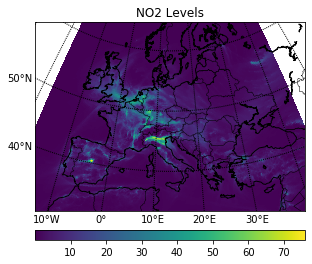

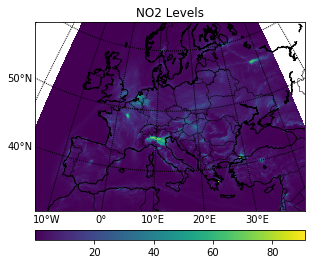

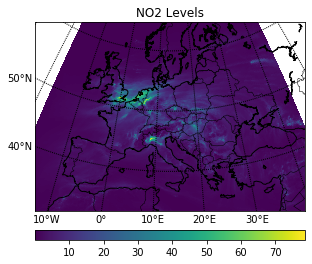

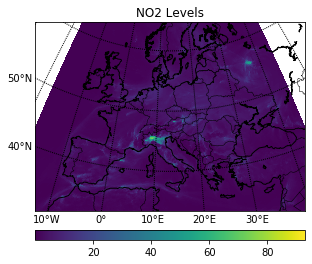

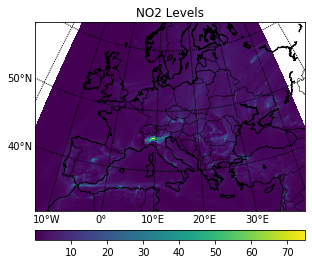

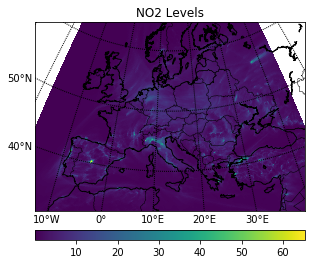

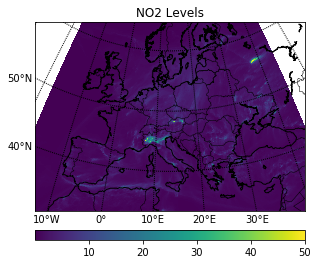

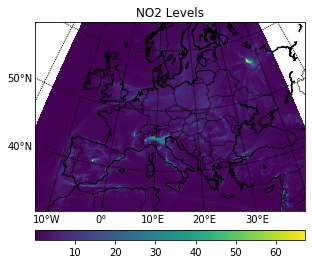

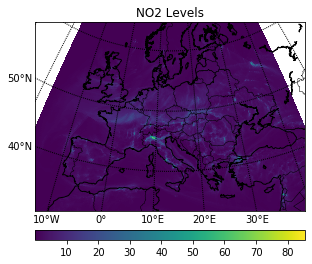

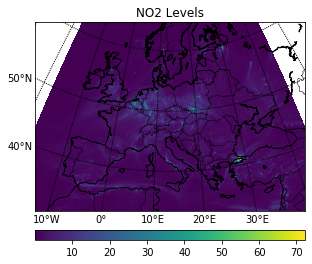

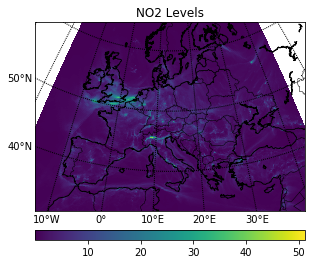

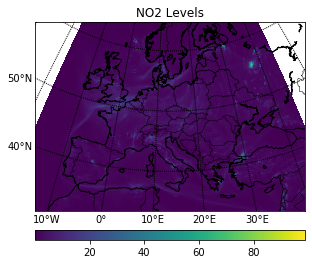

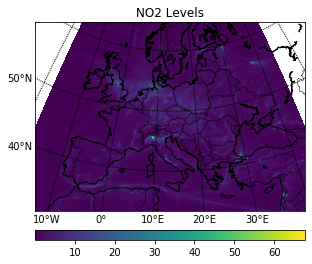

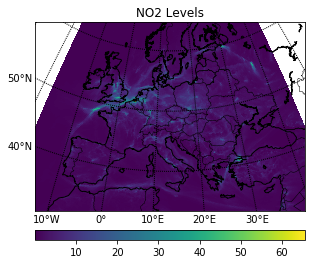

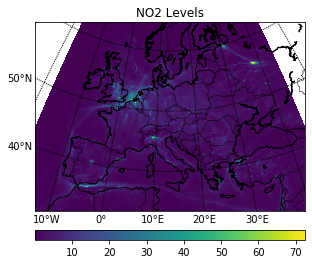

In [98]:
# NO2 Plots
for day in range(0,150,10):
    cs = m.pcolor(xi,yi,np.squeeze(no2[day][0]))

    # Grid Lines
    m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

    # Add Borders, Countries and Coastlines
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()

    cbar = m.colorbar(cs, location='bottom', pad="10%")

    plt.title('NO2 Levels')
    plt.show()

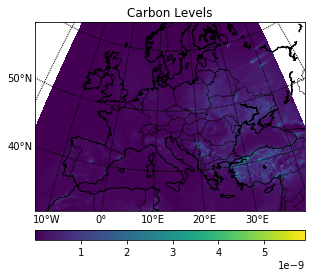

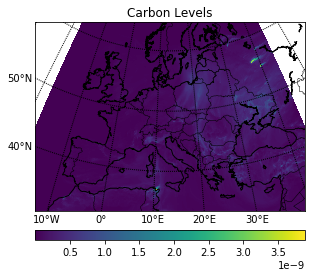

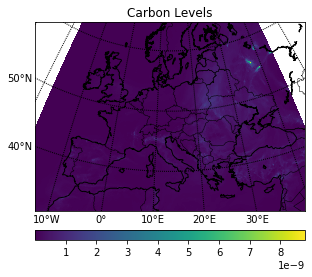

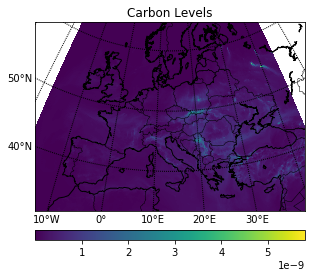

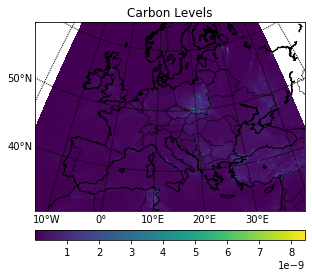

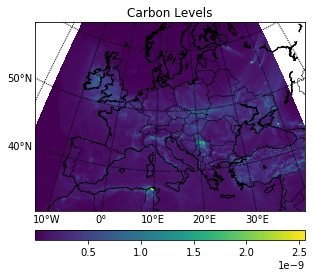

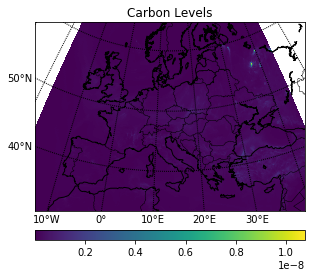

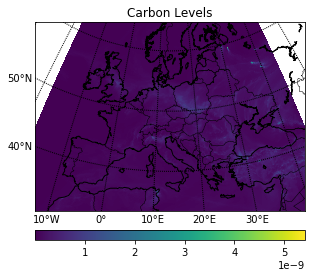

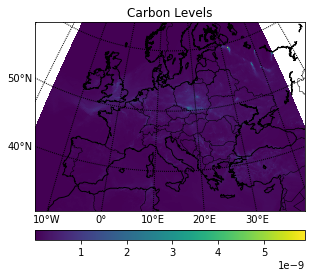

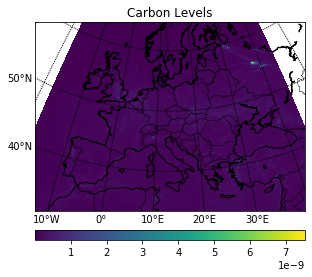

In [100]:
# Carbon Plots
for day in range(50,150,10):
    cs = m.pcolor(xi,yi,np.squeeze(carbon[day][0]))

    # Grid Lines
    m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

    # Add Borders, Countries and Coastlines
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()

    cbar = m.colorbar(cs, location='bottom', pad="10%")

    plt.title('Carbon Levels')
    plt.show()